#  Uncertainty-Aware Generative Evidential Networks

In [1]:
#%tensorflow_version 1.x

#import necessary libraries
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import scipy.ndimage as nd

%matplotlib inline
import pylab as pl
from IPython import display

#from tensorflow.examples.tutorials.mnist import input_data
from tensorflow_probability import distributions as tfd
from sklearn.metrics import roc_curve, precision_recall_curve, auc

C:\Users\A601\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\A601\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\A601\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\A601\AppData\Roaming\Python\Python37\site-pack

In [2]:
#optional: define which GPU will be used
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# define some utility functions
def var(name, shape, init=None):
    if init is None:
        # Initializer that generates a truncated normal distribution.
        init = tf.truncated_normal_initializer(stddev=(2/shape[0])**0.5)
    # create a new variable with these parameters.
    return tf.get_variable(name=name, shape=shape, dtype=tf.float32,
                          initializer=init)

def conv(Xin, f, strides=[1, 1, 1, 1], padding='SAME'):
    # Computes a 2-D convolution given input and 4-D filters tensors.
    return tf.nn.conv2d(Xin, f, strides, padding)

def max_pool(Xin, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME'):
    # Performs max pooling on the input.
    return tf.nn.max_pool(Xin, ksize, strides, padding)

def rotate_img(x, deg):
    import scipy.ndimage as nd
    return nd.rotate(x.reshape(32,32,3),deg,reshape=False).ravel()

In [5]:
def exp_evidence(logits): 
    return tf.exp(logits) 

def KL(alpha): 
    K=alpha.get_shape()[-1].value 
    beta=tf.constant(np.ones((1,K)),dtype=tf.float32)
    S_alpha = tf.reduce_sum(alpha,axis=1,keep_dims=True)
    S_beta = tf.reduce_sum(beta,axis=1,keep_dims=True)
    lnB = tf.lgamma(S_alpha) - tf.reduce_sum(tf.lgamma(alpha),axis=1,keep_dims=True)
    lnB_uni = tf.reduce_sum(tf.lgamma(beta),axis=1,keep_dims=True) - tf.lgamma(S_beta)
    
    dg0 = tf.digamma(S_alpha)
    dg1 = tf.digamma(alpha)
    
    kl = tf.reduce_sum((alpha - beta)*(dg1-dg0),axis=1,keep_dims=True) + lnB + lnB_uni
    return kl

In [6]:
def calc_entropy(p):
    return (-p*np.log(p+1e-8)).sum(1)

# Define the generative models

In [7]:
def disc(x, name='disc',K=5):
    with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
        x_inp = tf.reshape(x, [-1, 32, 32, 3]) 
        
        # l2正则化
        regularizer = tf.contrib.layers.l2_regularizer(scale=0.001)


        x = tf.layers.conv2d(inputs=x_inp, kernel_size=5, filters=192,
                         activation=tf.nn.relu, padding='VALID',
                         kernel_regularizer=regularizer,
                         kernel_initializer=tf.variance_scaling_initializer())
        x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                       padding='SAME')

        x = tf.layers.conv2d(inputs=x, kernel_size=5, filters=192,
                         activation=tf.nn.relu, padding='VALID',
                         kernel_regularizer=regularizer,
                         kernel_initializer=tf.variance_scaling_initializer())
        x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                       padding='SAME')

        x = tf.layers.flatten(x)

        x = tf.layers.dense(inputs=x, units=1000, activation=tf.nn.relu,
                        kernel_regularizer=regularizer,
                        kernel_initializer=tf.variance_scaling_initializer())

        x = tf.layers.dense(inputs=x, units=K,
                        kernel_regularizer=regularizer,
                        kernel_initializer=tf.variance_scaling_initializer())

        return x

In [8]:
layers_g = [{'filters': 256, 'kernel_size': [8, 8], 'strides': [1, 1], 'padding': 'valid'},
            {'filters': 128, 'kernel_size': [5, 5], 'strides': [2, 2], 'padding': 'same'},
            {'filters': 3, 'kernel_size': [5, 5], 'strides': [2, 2], 'padding': 'same'}]
    
def imgen(x): 
    # print(x.shape)
    if len(x.get_shape()) == 2: 
        m = x.get_shape()[1] 
        layer = tf.reshape(x, [-1, 1, 1, m])
    else:
        layer = x

    depth = len(layers_g) 
    for i in range(depth):
        layer_config = layers_g[i]
        is_output = ((i + 1) == depth)
        
        # print(layer.shape)
        conv2d = tf.layers.conv2d_transpose(
                    layer, 
                    filters = layer_config['filters'], 
                    kernel_size = layer_config['kernel_size'], 
                    strides = layer_config['strides'], 
                    padding = layer_config['padding'],
                    activation = tf.nn.tanh if is_output else None,
                    kernel_initializer = tf.truncated_normal_initializer(stddev=0.02), 
                    name = 'layer_' + str(i))

        if is_output:
            layer = conv2d
        else:
            norm = tf.layers.batch_normalization(conv2d, training=True) # Batch normalization
            lrelu = tf.nn.leaky_relu(norm) # Compute the Leaky ReLU activation function.
            layer = lrelu
    # print(layer.shape)            
    # [M, img_size, img_size, img_channels]
    output = tf.identity(layer, name='generated_images') # Return a Tensor with the same shape and contents as input.
    # print(output.shape)
    return output 

def encoder(x, n=100):
    with tf.variable_scope('encoder', reuse=tf.AUTO_REUSE):
        x = tf.reshape(x, [-1, 32, 32, 3])
        x = tf.layers.conv2d(x, 192, 5, activation=tf.nn.relu)
        x = tf.layers.max_pooling2d(x, 2, 2)

        x = tf.layers.conv2d(x, 192, 5, activation=tf.nn.relu)
        x = tf.layers.max_pooling2d(x, 2, 2)

        x = tf.layers.flatten(x)

        loc = tf.layers.dense(x, n)
        scale = tf.layers.dense(x, n, tf.nn.softplus)
        code = tfd.MultivariateNormalDiag(loc, scale).sample()
    
    return code

def make_prior(code_size):
    loc = tf.zeros(code_size)
    scale = tf.ones(code_size)
    return tfd.MultivariateNormalDiag(loc, scale) # The multivariate normal distribution 这里的loc和scale取值表示Identity scale, zero shift.



def decoder(code):
    with tf.variable_scope('decoder', reuse=tf.AUTO_REUSE):
        recon = imgen(code) 
    return recon

def gen(code):
    with tf.variable_scope('gen', reuse=tf.AUTO_REUSE):
        n = tf.shape(code)[0]
        m = code.get_shape()[1]
        x = tf.concat((tf.random_normal(shape=(n, 2)), code), 1)
        x = tf.layers.dense(x, 32, tf.nn.leaky_relu)
        x = tf.layers.dense(x, 32, tf.nn.leaky_relu)
        x = tf.layers.dense(x, 32, tf.nn.leaky_relu)
        std = tf.layers.dense(x, m, tf.nn.softplus) 
    return std

def diz(x): # the discriminator in latent space
    with tf.variable_scope('diz', reuse=tf.AUTO_REUSE):
        regularizer = tf.contrib.layers.l2_regularizer(scale=0.001)
        x = tf.layers.dense(x, 32, tf.nn.leaky_relu, kernel_regularizer=regularizer, bias_regularizer=regularizer)
        x = tf.layers.dense(x, 32, tf.nn.leaky_relu, kernel_regularizer=regularizer, bias_regularizer=regularizer)
        x = tf.layers.dense(x, 32, tf.nn.leaky_relu, kernel_regularizer=regularizer, bias_regularizer=regularizer)
        x = tf.layers.dense(x, 1, kernel_regularizer=regularizer, bias_regularizer=regularizer)
    return x

def wloss(logits, maximize=True ):
    labels = tf.ones_like(logits) if maximize else tf.zeros_like(logits) 
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels)) 

def autoencoder(X=None, n=5):
    if X is None:
        X = tf.placeholder(shape=[None,32*32*3], dtype=tf.float32) 
    code = encoder(X,n) 
     
    std = gen(code)
    pdf = tfd.MultivariateNormalDiag(loc=code, scale_diag=(std+1e-3)) # The multivariate normal distribution
    fake = pdf.sample() # Generate samples of the specified shape.
    

    rlogits = diz(code)
    r_p = tf.nn.sigmoid(rlogits) 
    
    flogits = diz(fake)
    f_p = tf.nn.sigmoid(flogits)
    
    recon = decoder(code) 
    Xfake = decoder(fake)   
    
    real_logits = disc(X,'disc0')
    real_p = tf.nn.sigmoid(real_logits)
    
    fake_logits = disc(Xfake,'disc0')
    fake_p = tf.nn.sigmoid(fake_logits)
        
    prior = make_prior(code_size=n)
        
    kl = -tf.reduce_mean(prior.log_prob(code)) 
    kl_fake = -tf.reduce_mean(prior.log_prob(fake))

    ae_vars = [v for v in tf.trainable_variables() if 'encoder/' in v.name or 'decoder/' in v.name] 
    gen_vars = [v for v in tf.trainable_variables() if 'gen/' in v.name]
    disc_vars = [v for v in tf.trainable_variables() if 'disc0/' in v.name]
    diz_vars = [v for v in tf.trainable_variables() if 'diz/' in v.name]
    
    
    loss_diz = tf.reduce_mean(rlogits)-tf.reduce_mean(flogits) ##
    
    loss_disc = tf.reduce_mean(real_logits)-tf.reduce_mean(fake_logits) ## 
    
    loss_gen = tf.reduce_mean(-tf.log(1-fake_p+1e-8))  + tf.reduce_mean(-tf.log(f_p+1e-8))
    
    ### need to revise
    recon = tf.layers.flatten(recon)
    rec_loss = tf.reduce_mean( tf.reduce_sum(tf.square(recon-X),1) + 1e-4) + 0.1*kl
    rec_loss += wloss(flogits, False)
    rec_step = tf.train.AdamOptimizer().minimize(rec_loss, var_list=ae_vars) # Optimizer that implements the Adam algorithm.
        
    diz_step = tf.train.RMSPropOptimizer(1e-4).minimize(loss_diz, var_list=diz_vars) # Optimizer that implements the RMSProp algorithm (Tielemans et al.
    disc_step = tf.train.RMSPropOptimizer(1e-4).minimize(loss_disc, var_list=disc_vars)
    gen_step = tf.train.RMSPropOptimizer(1e-4).minimize(loss_gen, var_list=gen_vars)
    
    rec_step = tf.group([rec_step for _ in range(10)]) # Create an operation that groups multiple operations.
    
    step = tf.group([rec_step, diz_step, disc_step, gen_step])
    return X, Xfake, code, recon, rec_loss, step

In [9]:
def misleading_alpha(alpha, y):
    K = y.get_shape()[-1].value
    indices = tf.where(tf.equal(y, tf.constant(0, dtype=tf.float32))) 
    alp = tf.gather_nd(alpha, indices) # Gather slices from params into a Tensor with shape specified by indices
    alp = tf.reshape(alp, [-1, K - 1])
    return alp

def loss_fn(Y, evidence, real_p, fake_p): 
    disc_loss = tf.reduce_mean(tf.reduce_sum(-Y * tf.log(real_p + 1e-5), axis=1) +
                               tf.reduce_sum(-Y * tf.log((1.0 - fake_p) + 1e-5), axis=1))
    alp = misleading_alpha(evidence+1, Y)
    disc_loss += tf.reduce_mean(KL(alp))
    return disc_loss

In [10]:
# train LeNet network
def LeNet(logits2evidence=exp_evidence, lmb=0.005,K=5):
    g = tf.Graph() # A TensorFlow computation, represented as a dataflow graph.
    with g.as_default():
        X = tf.placeholder(shape=[None,32*32*3], dtype=tf.float32) 
        Y = tf.placeholder(shape=[None,K], dtype=tf.float32) 
        adv_eps = tf.placeholder(dtype=tf.float32)   
    
        recon=None
        _, X_fake, code, recon, rec_loss, step_gen = autoencoder(X)
        
        real_logits = disc(X,K=K)
        real_p = tf.nn.sigmoid(real_logits)
        
        fake_logits = disc(X_fake,K=K)
        fake_p = tf.nn.sigmoid(fake_logits)
        
        evidence = logits2evidence(real_logits) 
        alpha = evidence + 1
        
        u = K / tf.reduce_sum(alpha, axis=1, keep_dims=True) #uncertainty
        
        prob = alpha/tf.reduce_sum(alpha, 1, keepdims=True) 
        
        
        var_disc = [v for v in tf.trainable_variables() if 'disc/' in v.name]
        
        l2_loss = tf.losses.get_regularization_loss()
        
#         disc_loss = tf.reduce_mean(tf.reduce_sum(-Y*tf.log(real_p + 1e-8), axis=1) + 
#                             tf.reduce_sum(-(1-Y)*tf.log(1.0-real_p + 1e-8), axis=1) +
#                             tf.reduce_sum(-tf.log((1.0-fake_p) + 1e-8), axis=1))
        
        disc_loss = loss_fn(Y, evidence, real_p, fake_p)
        
        
        step_disc = tf.train.AdamOptimizer().minimize(disc_loss + l2_loss, var_list = var_disc)
        
        
        loss_grads = tf.gradients(disc_loss, X)[0] 
        adv_x = X + adv_eps * tf.sign(loss_grads) 
        
        step = tf.group([step_disc, step_gen])
        
        # Calculate accuracy
        pred = tf.argmax(real_logits, 1) 
        truth = tf.argmax(Y, 1)
        match = tf.reshape(tf.cast(tf.equal(pred, truth), tf.float32),(-1,1)) 
        acc = tf.reduce_mean(match)
        
        total_evidence = tf.reduce_sum(evidence,1, keepdims=True) 
        mean_ev = tf.reduce_mean(total_evidence)
        mean_ev_succ = tf.reduce_sum(tf.reduce_sum(evidence,1, keepdims=True)*match) / tf.reduce_sum(match+1e-20)
        mean_ev_fail = tf.reduce_sum(tf.reduce_sum(evidence,1, keepdims=True)*(1-match)) / (tf.reduce_sum(tf.abs(1-match))+1e-20) 
        
        return g, step, X, Y, adv_eps, adv_x, recon, prob, acc, disc_loss, u, evidence, mean_ev, mean_ev_succ, mean_ev_fail, real_logits, X_fake

In [11]:
g, step, X, Y, adv_eps, adv_x, recon, prob, acc, loss, u, evidence, mean_ev, mean_ev_succ, mean_ev_fail, logits, X_fake = LeNet(exp_evidence)

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use `tf.keras.layers.Conv2DTranspose` instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch

In [12]:
config = tf.ConfigProto()
config.allow_soft_placement=True 
config.gpu_options.per_process_gpu_memory_fraction = 0.9  
config.gpu_options.allow_growth = True
sess = tf.Session(graph=g,config=config) 
with g.as_default():
    sess.run(tf.global_variables_initializer()) 

In [13]:
def get_dataset(dataset,labels, digits):
    digits=np.array([digits])
    y = labels.argmax(1)[:,None] ==digits 
    indx = (y.sum(1) > 0) 
    return dataset[indx],y[indx].astype(float)

def next_batch(data,labels, i, bsz):
    i = i % (data.shape[0]//bsz)
    return data[i*bsz:(i+1)*bsz], labels[i*bsz:(i+1)*bsz], np.arange(data.shape[0])[i*bsz:(i+1)*bsz] 

In [14]:
import scipy.io as scio

traindata = scio.loadmat('C:/Users/A601/Desktop/Files/Residual_Stress/Test/SVHN/train_32x32.mat')
x_train = traindata['X']/255
y_train = traindata['y']
x_train = x_train.transpose((3,0,1,2))

testdata = scio.loadmat('C:/Users/A601/Desktop/Files/Residual_Stress/Test/SVHN/test_32x32.mat')
x_test = testdata['X']/255
y_test = testdata['y']
x_test = x_test.transpose((3,0,1,2))

In [15]:
x_train = x_train.reshape([-1, 32*32*3])
x_test = x_test.reshape([-1, 32*32*3])
y_train = y_train[:,0]
y_test = y_test[:,0]

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(73257, 3072)
(73257,)
(26032, 3072)
(26032,)


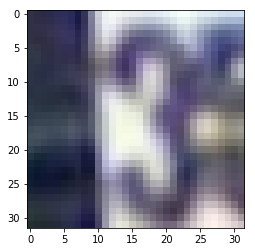

In [16]:
#digit_one = mnist.train.images[4].copy()
#plt.imshow(digit_one.reshape(28,28)) 
plt.imshow(x_train[6000].reshape(32,32,3)) 
plt.show()

In [17]:
K = 5 # number of classes

In [18]:
def y_resize(y_ori):
    y_matrix = np.zeros((len(y_ori),max(y_ori)))
    for i in range(len(y_ori)):
        if y_ori[i] == 10:
            y_ori[i] = 0
        y_matrix[i,y_ori[i]] = 1

    # print(y_train[0:5])
    # print(y_matrix[0:5])
    return y_matrix

In [19]:
y_train = y_resize(y_train)
y_test = y_resize(y_test)

In [20]:
print(y_train.shape)
print(y_test.shape)

(73257, 10)
(26032, 10)


In [21]:
in_labels = range(5)
out_labels = list(set(range(10))-set(in_labels))

x_train, y_train = get_dataset(x_train,y_train,in_labels)
x_out, y_out = get_dataset(x_test,y_test,out_labels)
x_test,y_test = get_dataset(x_test,y_test,in_labels)
OoD = x_out

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

print(OoD.shape[0])

(45349, 3072)
(45349, 5)
(16397, 3072)
(16397, 5)
9635


In [22]:
L_train_acc1=[]
L_train_ev_s=[]
L_train_ev_f=[]
L_test_acc1=[]
L_test_ev_s=[]
L_test_ev_f=[]

In [23]:
bsize = 500 #batch size
n_batches = 45349 // bsize

for epoch in range(0,100):   
    for i in range(n_batches):
        
        #data, label = mnist.train.next_batch(bsize)
        data,label,_ = next_batch(x_train,y_train, i,bsize) 
        
        feed_dict={X:data, Y:label}
        # print(data.shape)
        # print(label.shape)
        sess.run(step,feed_dict) 
        print('epoch %d - %d%%) '% (epoch+1, (100*(i+1))//n_batches), end='\r' if i<n_batches-1 else '')
 
    train_acc, train_succ, train_fail = sess.run([acc,mean_ev_succ,mean_ev_fail], 
                                                  feed_dict={X:x_train[0:1000],Y:y_train[0:1000]})
    test_acc, test_succ, test_fail = sess.run([acc,mean_ev_succ,mean_ev_fail], 
                                               feed_dict={X:x_test[0:1000],Y:y_test[0:1000]})
    
    L_train_acc1.append(train_acc)
    L_train_ev_s.append(train_succ)
    L_train_ev_f.append(train_fail)
    
    L_test_acc1.append(test_acc)
    L_test_ev_s.append(test_succ)
    L_test_ev_f.append(test_fail)
    
    print('training: %2.4f (%2.4f - %2.4f) \t testing: %2.4f (%2.4f - %2.4f)' % 
          (train_acc, train_succ, train_fail, test_acc, test_succ, test_fail))

epoch 1 - 100%) training: 0.4670 (5.0864 - 5.0034) 	 testing: 0.4540 (5.1529 - 5.1128)
epoch 2 - 100%) training: 0.7060 (3.8744 - 2.9822) 	 testing: 0.6180 (4.2970 - 3.2427)
epoch 3 - 100%) training: 0.8220 (36.9519 - 4.1003) 	 testing: 0.7640 (28.0406 - 4.3812)
epoch 4 - 100%) training: 0.8500 (159.5739 - 4.6082) 	 testing: 0.8190 (142.0358 - 3.8649)
epoch 5 - 100%) training: 0.8730 (424.4461 - 5.4380) 	 testing: 0.8140 (448.9903 - 3.9547)
epoch 6 - 100%) training: 0.8870 (1077.7441 - 6.3474) 	 testing: 0.8520 (1071.5864 - 4.1618)
epoch 7 - 100%) training: 0.8990 (1652.5341 - 6.9746) 	 testing: 0.8500 (1822.6375 - 4.2126)
epoch 8 - 100%) training: 0.8990 (2170.5718 - 7.3253) 	 testing: 0.8570 (3135.2466 - 4.2444)
epoch 9 - 100%) training: 0.9110 (2643.4734 - 7.5507) 	 testing: 0.8620 (4684.8247 - 4.2810)
epoch 10 - 100%) training: 0.9120 (4241.1396 - 8.5422) 	 testing: 0.8760 (9579.6807 - 4.4528)
epoch 11 - 100%) training: 0.9120 (11594.2139 - 11.4050) 	 testing: 0.8870 (38532.8281 - 

epoch 81 - 100%) training: 0.9780 (6475125981446144.0000 - 3.0769) 	 testing: 0.9240 (3965691480768512.0000 - 125.0651)
epoch 82 - 100%) training: 0.9810 (20253053575757824.0000 - 3.1706) 	 testing: 0.9280 (3803612836790272.0000 - 54.0122)
epoch 83 - 100%) training: 0.9790 (10936510375264256.0000 - 3.0523) 	 testing: 0.9190 (2459697705648128.0000 - 71.0883)
epoch 84 - 100%) training: 0.9810 (2062435108257792.0000 - 3.7843) 	 testing: 0.9190 (621395667058688.0000 - 57.3190)
epoch 85 - 100%) training: 0.9740 (24520322627665920.0000 - 3.1433) 	 testing: 0.9210 (45776401390895104.0000 - 56.5270)
epoch 86 - 100%) training: 0.9750 (17896443675148288.0000 - 3.7772) 	 testing: 0.9080 (14428238256275456.0000 - 42.8784)
epoch 87 - 100%) training: 0.9800 (3618275065856000.0000 - 3.1105) 	 testing: 0.9140 (6624332608438272.0000 - 73.7176)
epoch 88 - 100%) training: 0.9800 (445918268620800.0000 - 3.5007) 	 testing: 0.9150 (753813468217344.0000 - 147.4620)
epoch 89 - 100%) training: 0.9780 (17775279

# Some generated fake images

In [24]:
def get_image(data)
    n = int(data.shape[0]**0.5)
    m = int(np.ceil(data.shape[0]/n))
    I = np.zeros((n*32,m*32,3))
    # print(I.shape)
    # print(data[0].shape)
    for i in range(n):
        for j in range(m):
            I[i*32:(i+1)*32,j*32:(j+1)*32,:] = data[i*m+j].reshape(32,32,3)
            # print(I)
    # print(I.shape)
    return I

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


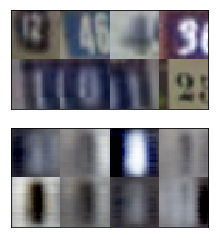

In [25]:
org = get_image(x_test[100:108])
fake = get_image(sess.run(X_fake, {X:x_test[100:108]}))
plt.subplot(2,1,1)
plt.xticks([])
plt.yticks([])
plt.imshow(org)

plt.subplot(2,1,2)
plt.xticks([])
plt.yticks([])
plt.imshow(fake)

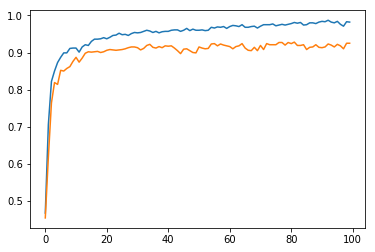

In [26]:
plt.plot(L_train_acc1)
plt.plot(L_test_acc1)

# Image Rotation Test

In [27]:
# def roc_test(x_test=x_test[0:500], x_out=x_out[0:500]):
#     normal = x_test
#     anormal = x_out[:normal.shape[0]]
#     truth = np.ones((normal.shape[0]+anormal.shape[0],))
#     truth[normal.shape[0]:]=0
#     imgs = np.concatenate((normal,anormal),0)
#     ev = sess.run(evidence, feed_dict={X:imgs}).sum(1) 

#     fpr, tpr, roc_thresholds = roc_curve(truth, ev) 
#     roc_auc = auc(fpr, tpr)

#     print('roc:',roc_auc)

In [28]:
# roc_test()

In [29]:
# rotating_image_classification(x_train[5], sess, prob, X, None, u, prob_threshold=0.2)

# Entropy as Predictive Uncertainy (correct vs wrong predictions)

In [30]:
test_acc, ev = sess.run([acc,evidence], feed_dict={X:x_test[0:1000],Y:y_test[0:1000]})

In [31]:
match = (ev.argmax(1)==y_test[0:1000].argmax(1)) 
succ_ev = ev[match]
fail_ev = ev[(1-match).astype(bool)]

# u_succ = 10/(10+succ_ev.sum(1))
# u_fail = 10/(10+fail_ev.sum(1))

p_succ = (succ_ev+1)/(10+succ_ev.sum(1,keepdims=True))
p_fail = (fail_ev+1)/(10+fail_ev.sum(1,keepdims=True))

In [32]:
# plt.hist(calc_entropy(p_fail))

In [33]:
# plt.hist(calc_entropy(p_succ))

# Subjective Logic's Uncertainty (K/S)

In [34]:
# a_=plt.hist(u_succ, bins='auto')

In [35]:
# a_=plt.hist(u_fail, bins='auto')

# Emprical PDF for Entropy for Out-of-Distribution (OoD) Samples

In [36]:
p_OoD=sess.run(prob, feed_dict={X:OoD[0:1000].reshape(-1,32*32*3)})

In [37]:
def entropy(p):
    return (-p*np.log(p+1e-8)).sum(1) 

In [38]:
def empCDF(entropy,n=5): 
    x = np.linspace(0,np.log(n), 1000)
    y = np.zeros_like(x)
    for i, val in enumerate(x): 
        y[i] = np.mean(entropy<=val)
    return entropy, x,y

In [39]:
_,x,y=empCDF(entropy(p_OoD))

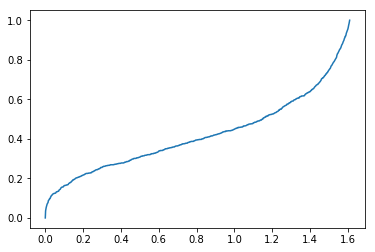

In [40]:
plt.plot(x,y)

# Emprical PDF for Entropy for correct and wrong predictions

In [41]:
_,x1,y1=empCDF(entropy(p_succ))

(0, 1)

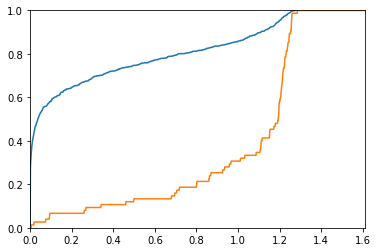

In [42]:
_,x2,y2=empCDF(entropy(p_fail))
plt.plot(x1,y1)
plt.plot(x2,y2)
plt.xlim([0,np.log(5)])
plt.ylim([0,1])

# OoD Detection using Entropy of Predictions

In [43]:
normal = x_test[0:500]
anormal = OoD[0:500].reshape(-1,32*32*3)

truth = np.ones((normal.shape[0]+anormal.shape[0],))
truth[normal.shape[0]:]=0
imgs = np.concatenate((normal,anormal),0)

In [44]:
ev = sess.run(evidence, feed_dict={X:imgs})

In [45]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

fpr, tpr, roc_thresholds = roc_curve(truth, ev.sum(1))
roc_auc = auc(fpr, tpr)

In [46]:
roc_auc

0.7842560000000001

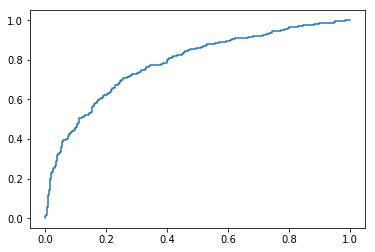

In [47]:
plt.plot(fpr,tpr)

In [48]:
np.savez('results/SVHN_ACC_wgan.npz', L_train_acc1,L_test_acc1)
np.savez('results/SVHN_ROC_wgan.npz', fpr,tpr)
np.savez('results/SVHN_p_succ_fail_wgan.npz', x1,y1,x2,y2)
np.savez('results/SVHN_entropy_wgan',x,y)
np.savez('results/SVHN_images_wgan.npz', org,fake)